<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>Исследование поведения аудитории: 4. </h1> 
<hr style='border:2px solid #460073'> </hr>
<h3 style='color: #460073'>Автор: </h3> 

* Бессонов Евгений  
* [Адрес в телеграмм](https://t.me/EMskv "t.me/EMskv")  
* [Портфолио с JupiterNotebook проекта](https://github.com/evgeniy-yandex/Data_Science "github")
    
<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>Описание проекта. </h1> 
<hr style='border:2px solid #460073'> </hr>
<h3 style='color: #460073'>Описание данных. </h3> 

Для работы получены файл `Reach000%.xlsx`

Предоставленные массивы данных об отдельных аудиториях диджитал-ресурсов среди населения России в возрасте 12 лет и старше в динамике за 3 месяца. Содержаться как общие показатели среди населения, так и в разбивке на возрастные группы и устройство контакта - Web Desktop (ПК и ноутбуки), App Mobile (Мобильное приложение), Web Mobile (Мобильный браузер).
Все файлы содержат идентичный набор ресурсов за один и тот же период.

<h3 style='color: #460073'>Описание метрик: </h3> 

|<!-- -->|<!-- -->|  
|:------:|:-------|
|Reach|Reach|
| |Количество человек в генеральной совокупности или в заданной соц.-дем. группе, которые зашли на страницы/ открыли приложения медиа объекта, входящие в него, хотя бы один раз за указанный период.|
|ReachPer|Reach%|
| |Количество человек, заходивших на медиа объект хотя бы один раз за указанный период, в % от генеральной совокупности или заданной соц.-дем. группы.!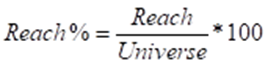|
<h3 style='color: #460073'>Задача на проект 3. </h3> 

Провести анализ EDA данных из файла `Reach000%` с метриками `Reach` и `ReachPer`:  
1. Описать, какие основные тренды видите.
2. Какие особенности в структуре и поведении аудитории ресурсов?
3. Какие причины изменений показателей динамики для конкретного ресурса?

<h3 style='color: #460073'>План работы. </h3> 

1. Импорт библиотек.
2. Загрузка файлов с данными `Reach000%`
3. Изучение датасетов и проведение первичной обработки данных.
    * Размеры датасетов.
    * Сущность признаков.
    * Типы данных.
    * Наличие/отсутствие дубликатов.
    * Наличие/отсутствие пропусков данных.
4. Проведение EDA анализа. 
    * Приведение к формату 'datetime' данных со значениями времени.
    * Выполнение для выбранных источников информации по каждой из шести возрастных групп:
        * `до 12 лет`, 
        * `от 12 до 24 лет`, 
        * `от 24 до 34 лет`,
        * `от 34 до 44 лет`,
        * `от 44 до 54 лет`,
        * `от 55 лет`   
        следующих работ:
        * Графическое представление.
        * Анализ на наличие трендов и сезонности.
        * Оценка стационарности временного ряда. Тест Дики-Фуллера (Dickey-Fuller test).
    * (`примечание`. Для суммарных, по всем возрастных категорий пользователей анализ проводить не будем. Проведем сравнение по возрастным группам).
5. Оформление итоговых выводов. 

<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>1. Импорт библиотек. </h1> 
<hr style='border:2px solid #460073'> </hr>

In [1]:
# Все import соберем в начале проекта:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import seaborn as sns
import re
import numpy as np

from skimpy import skim, clean_columns
from datetime import datetime
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

# В датасете 150 признаков: 50 Источников x 6 параметров
NUM_FEATURES = 3 # Ограничимся 3 источниками для демо-проекта

# Размер окна для проверки стационарности временного ряда
WINDOW_STATIONARITY = 7

# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50) 

# Настроим, чтобы числа в датасетах отражались с 3 знаками после запятой
pd.set_option('display.float_format', '{:.2f}'.format) 

<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>2. Загрузка файлов с данными.</h1> 
<hr style='border:2px solid #460073'> </hr>

Изучил файл `Reach000%.xlsx`, привёл его к формату `csv` и разделил на 2 файла:

In [2]:
# Вспомогательная функция для чтения файлов с данными
def load_dataset(file_name, separator):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        data = pd.read_csv(file_name, sep = separator)
        print('Dataset "', file_name, '" is loaded successfully.', sep='')
        return data
    else:
        print('Something with', file_name, 'is wrong!')

In [3]:
# Загрузка данных по фактическому включению/выключению пиплметра         
df_reach_total = load_dataset('Reach000%_total.csv', ';')
df_reach_3 = load_dataset('Reach000%_3.csv', ';')

Dataset "Reach000%_total.csv" is loaded successfully.
Dataset "Reach000%_3.csv" is loaded successfully.


<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>3. Изучение датасета и проведение первичной обработки данных.</h1> 
<hr style='border:2px solid #460073'> </hr>

Создаю вспомогательную функцию для изучения датафреймов.

In [4]:
def view_skim_df(df):
    '''
    Функция для единообразного изучения датафреймов.
    1. Контроль размера датафрейма.
    2. Вывод основных данных по датафрейму.
    3. Распечатка на экране первых трёх объектов датафрейма.
    '''
    skim(df)
    display(df.head(3))
    print('Количество дубликатов:', df.duplicated().sum())    
    print('Полное количество пропущенных значений по всем признакам:', 
          df.isnull().sum().sum())
    
    return

## 3.1. Рассмотрим данные, содержащиеся в датафрейме 'Reach000%_total'.

In [5]:
# Изучим содержимое датафрейма:
view_skim_df(df_reach_total)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 25     │ │ string      │ 13    │                                                          │
│ │ Number of columns │ 19     │ │ float64     │ 6     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA   ┃ NA %   ┃ mean   ┃ sd    ┃ p0     ┃ p25    ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Апрель 2023 Web Desk         │    0 │      0 │      8 │   9.5 │   0.04 │    1.1 │    10 │     31 │ █▃▁ ▁▂  │  │
│ │ Апрель 2023 Web Mobi         │    0 │      0 │     12 │    15 │   0.09 │      2 │    16 │     57 │ █▃▁▁ ▁  │  │
│ │ Май 2023 Web Desktop         │    0 │      0 │      8 │   9.4 │   0.03 │      1 │    11 │     31 │ █▄▂ ▁▂  │  │
│ │ Май 2023 Web Mobile          │    0 │      0 │     12 │    15 │   0.09 │    2.6 │    15 │     58 │ █▂▁  ▁  │  │
│ │ Июнь 2023 Web Deskto         │    0 │      0 │    7.3 │   8.6 │   0.02 │   0.99 │   9.6 │     28 │ █▂▂▁ ▂  │  │
│ │ Июнь 2023 Web Mobile         │    0 │      0 │     11 │    14 │   0.09 │    2.6 │    14 │     55 │ █▂   ▁  │  │
│ └──────────────────────────────┴──────┴────────┴────────┴───────┴────────┴────────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                           ┃ NA    ┃ NA %      ┃ words per row            ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Name                                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Апрель 2023 Web Desk                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Апрель 2023 App Mobi                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Апрель 2023 App Mobi                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Апрель 2023 Web Mobi                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Май 2023 Web Desktop                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Май 2023 App Mobile                   │     0 │         0 │                      1.2 │                  30 │  │
│ │ Май 2023 App Mobile                   │     0 │         0 │                      1.2 │                  30 │  │
│ │ Май 2023 Web Mobile                   │     0 │         0 │                      1.2 │                  30 │  │
│ │ Июнь 2023 Web Deskto                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Июнь 2023 App Mobile                  │     0 │         0 │                      1.2 │                  30 │  │
│ │ Июнь 2023 App Mobile                  │     0 │     

Name Апрель 2023 Web Desktop Reach  Апрель 2023 Web Desktop ReachPer  \
0      2gis                     6 726 477                              5.52   
1   Discord                     3 983 267                              3.27   
2  Facebook                     1 323 813                              1.09   

  Апрель 2023 App Mobile Reach Апрель 2023 App Mobile ReachPer  \
0                   18 460 867                           15.16   
1                    7 650 027                            6.28   
2                    8 462 283                            6.95   

  Апрель 2023 Web Mobile Reach  Апрель 2023 Web Mobile ReachPer  \
0                   11 626 513                             9.55   
1                    2 437 420                             2.00   
2                   15 061 037                            12.37   

  Май 2023 Web Desktop Reach  Май 2023 Web Desktop ReachPer  \
0                  6 470 648                           5.31   
1                  3 830 706                           3.15   
2                  1 214 148                           1.00   

  Май 2023 App Mobile Reach Май 2023 App Mobile ReachPer  \
0                18 870 329                         15.5   
1                 7 835 784                         6.44   
2                 7 917 942                          6.5   

  Май 2023 Web Mobile Reach  Май 2023 Web Mobile ReachPer  \
0                11 872 900                          9.75   
1                 2 554 781                          2.10   
2                15 024 400                         12.34   

  Июнь 2023 Web Desktop Reach  Июнь 2023 Web Desktop ReachPer  \
0                   5 809 808                            4.77   
1                   3 323 862                            2.73   
2                   1 008 692                            0.83   

  Июнь 2023 App Mobile Reach Июнь 2023 App Mobile ReachPer  \
0                 18 047 392                         14.82   
1                  7 103 642                          5.83   
2                  7 099 569                          5.83   

  Июнь 2023 Web Mobile Reach  Июнь 2023 Web Mobile ReachPer  
0                 10 940 673                           8.99  
1                  1 803 812                           1.48  
2                 13 510 750                          11.10

Количество дубликатов: 0
Полное количество пропущенных значений по всем признакам: 0


In [6]:
list_columns_total = list(df_reach_total.columns[1:]) # Убрал Name

In [7]:
df_reach_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Name                              25 non-null     object 
 1   Апрель 2023 Web Desktop Reach     25 non-null     object 
 2   Апрель 2023 Web Desktop ReachPer  25 non-null     float64
 3   Апрель 2023 App Mobile Reach      25 non-null     object 
 4   Апрель 2023 App Mobile ReachPer   25 non-null     object 
 5   Апрель 2023 Web Mobile Reach      25 non-null     object 
 6   Апрель 2023 Web Mobile ReachPer   25 non-null     float64
 7   Май 2023 Web Desktop Reach        25 non-null     object 
 8   Май 2023 Web Desktop ReachPer     25 non-null     float64
 9   Май 2023 App Mobile Reach         25 non-null     object 
 10  Май 2023 App Mobile ReachPer      25 non-null     object 
 11  Май 2023 Web Mobile Reach         25 non-null     object 
 12  Май 2023 W

**Отмечаем**:
* Количество записей 25.
* Количество признаков равно 19. Всем, кроме `Name` необходимы преобразования типов в *float*.
* Дубликатов нет. 
* Пропуски данных заменены на nan.

## 3.2. Рассмотрим данные, содержащиеся в датафрейме 'Reach000%_3'.

In [8]:
# Изучим содержимое датафрейма:
view_skim_df(df_reach_3)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 75     │ │ string      │ 17    │                                                          │
│ │ Number of columns │ 32     │ │ float64     │ 15    │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA   ┃ NA %   ┃ mean   ┃ sd    ┃ p0     ┃ p25    ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Возрастные группы:12         │    0 │      0 │     11 │    14 │      0 │   0.77 │    14 │     49 │ █▂▁▁ ▁  │  │
│ │ Возрастные группы:12         │    9 │     12 │     29 │    32 │      0 │    2.1 │    55 │     87 │ █▂▁▁▁▃  │  │
│ │ Возрастные группы:12         │    0 │      0 │     14 │    19 │      0 │    1.8 │    17 │     74 │   █▂    │  │
│ │ Возрастные группы:25         │    0 │      0 │    8.5 │    11 │      0 │    1.1 │    10 │     38 │ █▃▁▁ ▁  │  │
│ │ Возрастные группы:25         │    7 │    9.3 │     27 │    29 │      0 │    3.7 │    49 │     87 │ █▁▂▁ ▃  │  │
│ │ Возрастные группы:25         │    0 │      0 │     14 │    18 │   0.03 │    2.8 │    17 │     69 │ █▃▁▁ ▁  │  │
│ │ Возрастные группы:35         │    0 │      0 │    8.7 │    10 │      0 │    1.3 │    12 │     34 │ █▂▁ ▁▁  │  │
│ │ Возрастные группы:35         │    6 │      8 │     26 │    28 │      0 │    1.3 │    45 │     87 │ █▁▃▁▁▂  │  │
│ │ Возрастные группы:35         │    0 │      0 │     14 │    18 │   0.06 │    2.4 │    18 │     71 │ █▃▁  ▁  │  │
│ │ Возрастные группы:45         │    0 │      0 │    8.6 │    10 │   0.03 │    1.2 │    14 │     33 │ █▂▂  ▂  │  │
│ │ Возрастные группы:45         │    6 │      8 │     22 │    25 │      0 │    1.3 │    35 │     80 │ █▁▃▁▁▁  │  │
│ │ Возрастные группы:45         │    0 │      0 │     13 │    16 │   0.06 │      2 │    17 │     67 │   █▂▁   │  │
│ │ Возрастные группы:55         │    0 │      0 │    5.3 │   6.1 │   0.05 │   0.84 │   7.3 │     22 │ █▂▁▁▁▁  │  │
│ │ Возрастные группы:55         │    6 │      8 │     13 │    15 │      0 │   0.73 │    22 │     51 │ █▂▂▁▁▁  │  │
│ │ Возрастные группы:55         │    0 │      0 │    7.9 │    10 │   0.11 │    1.6 │    11 │     43 │   █▂▁   │  │
│ └──────────────────────────────┴──────┴────────┴────────┴───────┴────────┴────────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                           ┃ NA    ┃ NA %      ┃ words per row            ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ source                                │     0 │         0 │                      1.2 │                  90 │  │
│ │ Возрастные группы:12                  │     0 │         0 │                      1.2 │                  90 │  │
│ │ Возрастные группы:12                  │     0 │     

source Возрастные группы:12-24 Web Desktop Reach  \
0      2gis                                   955 840   
1   Discord                                 1 965 777   
2  Facebook                                   228 940   

   Возрастные группы:12-24 Web Desktop ReachPer  \
0                                          5.08   
1                                         10.45   
2                                          1.22   

  Возрастные группы:12-24 App Mobile Reach  \
0                                2 993 957   
1                                4 827 237   
2                                1 152 267   

   Возрастные группы:12-24 App Mobile ReachPer  \
0                                        15.91   
1                                        25.66   
2                                         6.12   

  Возрастные группы:12-24 Web Mobile Reach  \
0                                1 627 023   
1                                1 166 850   
2                                4 127 083   

   Возрастные группы:12-24 Web Mobile ReachPer  \
0                                         8.65   
1                                         6.20   
2                                        21.94   

  Возрастные группы:25-34 Web Desktop Reach  \
0                                 1 373 833   
1                                   876 937   
2                                   220 830   

   Возрастные группы:25-34 Web Desktop ReachPer  \
0                                          7.07   
1                                          4.51   
2                                          1.14   

  Возрастные группы:25-34 App Mobile Reach  \
0                                4 949 223   
1                                1 480 170   
2                                1 683 943   

   Возрастные группы:25-34 App Mobile ReachPer  \
0                                        25.48   
1                                         7.62   
2                                         8.67   

  Возрастные группы:25-34 Web Mobile Reach  \
0                                2 604 003   
1                                  501 583   
2                                3 038 407   

   Возрастные группы:25-34 Web Mobile ReachPer  \
0                                        13.40   
1                                         2.58   
2                                        15.64   

  Возрастные группы:35-44 Web Desktop Reach  \
0                                 1 498 160   
1                                   627 103   
2                                   239 503   

   Возрастные группы:35-44 Web Desktop ReachPer  \
0                                          6.54   
1                                          2.74   
2                                          1.05   

  Возрастные группы:35-44 App Mobile Reach  \
0                                4 645 593   
1                                  779 387   
2                                2 069 570   

   Возрастные группы:35-44 App Mobile ReachPer  \
0                                        20.27   
1                                         3.40   
2                                         9.03   

  Возрастные группы:35-44 Web Mobile Reach  \
0                                3 120 677   
1                                  361 743   
2                                3 236 577   

   Возрастные группы:35-44 Web Mobile ReachPer  \
0                                        13.62   
1                                         1.58   
2                                        14.12   

  Возрастные группы:45-54 Web Desktop Reach  \
0                                 1 112 303   
1                                   308 407   
2                                   224 937   

   Возрастные группы:45-54 Web Desktop ReachPer  \
0                                          5.96   
1                                          1.65   
2                                          1.21   

  Возрастные группы:45-54 App Mobile Reach  \
0                          

Количество дубликатов: 0
Полное количество пропущенных значений по всем признакам: 34


In [9]:
list_columns_3 = list(df_reach_3.columns[1:-1]) # Убрал Name и month

**Отмечаем**:
* Количество записей 25.
* Количество признаков равно 31. Всем признакам с типом 'object', кроме `resource` необходимы преобразования типов в *float*.
* Дубликатов нет. 
* Пропуски данных заменены на nan.

<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>4. EDA анализ.</h1> 
<hr style='border:2px solid #460073'> </hr>

## 4.1. Коррекция типов 'oblect' признаков.

### 4.1.1. Приведение к формату 'float' признаков с датасета `df_reach_total`.

In [10]:
# Уберём пробелы в начале и в конце информационных признаках:
df_reach_total[list_columns_total] = \
    df_reach_total[list_columns_total].replace(r"^ +| +$", r"", regex=True)
# Уберём пробелы в середине признаков':
df_reach_total[list_columns_total] = \
    df_reach_total[list_columns_total].replace(r'\s+', '', regex=True)

fea_object_float = {}
for fea in list_columns_total:
    fea_object_float[fea] = 'float'

df_reach_total = df_reach_total.astype(fea_object_float)
df_reach_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Name                              25 non-null     object 
 1   Апрель 2023 Web Desktop Reach     25 non-null     float64
 2   Апрель 2023 Web Desktop ReachPer  25 non-null     float64
 3   Апрель 2023 App Mobile Reach      23 non-null     float64
 4   Апрель 2023 App Mobile ReachPer   22 non-null     float64
 5   Апрель 2023 Web Mobile Reach      25 non-null     float64
 6   Апрель 2023 Web Mobile ReachPer   25 non-null     float64
 7   Май 2023 Web Desktop Reach        25 non-null     float64
 8   Май 2023 Web Desktop ReachPer     25 non-null     float64
 9   Май 2023 App Mobile Reach         23 non-null     float64
 10  Май 2023 App Mobile ReachPer      22 non-null     float64
 11  Май 2023 Web Mobile Reach         25 non-null     float64
 12  Май 2023 W

**Отмечаем**, что преобразования типов выполнены полностью.

In [11]:
df_reach_total.head()

Name  Апрель 2023 Web Desktop Reach  \
0            2gis                     6726477.00   
1         Discord                     3983267.00   
2        Facebook                     1323813.00   
3    Google Карты                     5050247.00   
4  Google Новости                       91760.00   

   Апрель 2023 Web Desktop ReachPer  Апрель 2023 App Mobile Reach  \
0                              5.52                   18460867.00   
1                              3.27                    7650027.00   
2                              1.09                    8462283.00   
3                              4.15                   30605257.00   
4                              0.08                     871037.00   

   Апрель 2023 App Mobile ReachPer  Апрель 2023 Web Mobile Reach  \
0                            15.16                   11626513.00   
1                             6.28                    2437420.00   
2                             6.95                   15061037.00   
3                            25.14                    1752010.00   
4                             0.72                     138050.00   

   Апрель 2023 Web Mobile ReachPer  Май 2023 Web Desktop Reach  \
0                             9.55                  6470648.00   
1                             2.00                  3830706.00   
2                            12.37                  1214148.00   
3                             1.44                  5290565.00   
4                             0.11                   103632.00   

   Май 2023 Web Desktop ReachPer  Май 2023 App Mobile Reach  \
0                           5.31                18870329.00   
1                           3.15                 7835784.00   
2                           1.00                 7917942.00   
3                           4.35                31627194.00   
4                           0.09                  795710.00   

   Май 2023 App Mobile ReachPer  Май 2023 Web Mobile Reach  \
0                         15.50                11872900.00   
1                          6.44                 2554781.00   
2                          6.50                15024400.00   
3                         25.98                 1575155.00   
4                          0.65                  146619.00   

   Май 2023 Web Mobile ReachPer  Июнь 2023 Web Desktop Reach  \
0                          9.75                   5809808.00   
1                          2.10                   3323862.00   
2                         12.34                   1008692.00   
3                          1.29                   4885319.00   
4                          0.12                    120731.00   

   Июнь 2023 Web Desktop ReachPer  Июнь 2023 App Mobile Reach  \
0                            4.77                 18047392.00   
1                            2.73                  7103642.00   
2                            0.83                  7099569.00   
3                            4.01                 29906723.00   
4                            0.10                   802777.00   

   Июнь 2023 App Mobile ReachPer  Июнь 2023 Web Mobile Reach  \
0                          14.82                 10940673.00   
1                           5.83                  1803812.00   
2                           5.83                 13510750.00   
3                          24.56                  1368192.00   
4                           0.66                   128946.00   

   Июнь 2023 Web Mobile ReachPer  
0                           8.99  
1                           1.48  
2                          11.10  
3                           1.12  
4                           0.11

### 4.1.2. Приведение к формату 'float' признаков с датасета `df_reach_3`.

In [12]:
# Уберём пробелы в начале и в конце информационных признаках:
df_reach_3[list_columns_3] = \
    df_reach_3[list_columns_3].replace(r"^ +| +$", r"", regex=True)
# Уберём пробелы в середине признаков':
df_reach_3[list_columns_3] = \
    df_reach_3[list_columns_3].replace(r'\s+', '', regex=True)

fea_object_float = {}
for fea in list_columns_3:
    fea_object_float[fea] = 'float'

df_reach_3 = df_reach_3.astype(fea_object_float)
df_reach_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   source                                        75 non-null     object 
 1   Возрастные группы:12-24 Web Desktop Reach     75 non-null     float64
 2   Возрастные группы:12-24 Web Desktop ReachPer  75 non-null     float64
 3   Возрастные группы:12-24 App Mobile Reach      66 non-null     float64
 4   Возрастные группы:12-24 App Mobile ReachPer   66 non-null     float64
 5   Возрастные группы:12-24 Web Mobile Reach      75 non-null     float64
 6   Возрастные группы:12-24 Web Mobile ReachPer   75 non-null     float64
 7   Возрастные группы:25-34 Web Desktop Reach     75 non-null     float64
 8   Возрастные группы:25-34 Web Desktop ReachPer  75 non-null     float64
 9   Возрастные группы:25-34 App Mobile Reach      68 non-null     float

In [13]:
df_reach_3.head()

source  Возрастные группы:12-24 Web Desktop Reach  \
0            2gis                                  955840.00   
1         Discord                                 1965777.00   
2        Facebook                                  228940.00   
3    Google Карты                                 1058733.00   
4  Google Новости                                    7070.00   

   Возрастные группы:12-24 Web Desktop ReachPer  \
0                                          5.08   
1                                         10.45   
2                                          1.22   
3                                          5.63   
4                                          0.04   

   Возрастные группы:12-24 App Mobile Reach  \
0                                2993957.00   
1                                4827237.00   
2                                1152267.00   
3                                7197940.00   
4                                  72957.00   

   Возрастные группы:12-24 App Mobile ReachPer  \
0                                        15.91   
1                                        25.66   
2                                         6.12   
3                                        38.26   
4                                         0.39   

   Возрастные группы:12-24 Web Mobile Reach  \
0                                1627023.00   
1                                1166850.00   
2                                4127083.00   
3                                 584887.00   
4                                   1793.00   

   Возрастные группы:12-24 Web Mobile ReachPer  \
0                                         8.65   
1                                         6.20   
2                                        21.94   
3                                         3.11   
4                                         0.01   

   Возрастные группы:25-34 Web Desktop Reach  \
0                                 1373833.00   
1                                  876937.00   
2                                  220830.00   
3                                 1176047.00   
4                                     240.00   

   Возрастные группы:25-34 Web Desktop ReachPer  \
0                                          7.07   
1                                          4.51   
2                                          1.14   
3                                          6.05   
4                                          0.00   

   Возрастные группы:25-34 App Mobile Reach  \
0                                4949223.00   
1                                1480170.00   
2                                1683943.00   
3                                6218073.00   
4                                 166567.00   

   Возрастные группы:25-34 App Mobile ReachPer  \
0                                        25.48   
1                                         7.62   
2                                         8.67   
3                                        32.01   
4                                         0.86   

   Возрастные группы:25-34 Web Mobile Reach  \
0                                2604003.00   
1                                 501583.00   
2                                3038407.00   
3                                 375423.00   
4                                  15933.00   

   Возрастные группы:25-34 Web Mobile ReachPer  \
0                                        13.40   
1                                         2.58   
2                                        15.64   
3                                         1.93   
4                                         0.08   

   Возрастные группы:35-44 Web Desktop Reach  \
0                                 1498160.00   
1                                  627103.00   
2                                  239503.00   
3                                 1124233.00   
4                                    7097.00   

   Возрастные группы:35-44 Web Desktop ReachPer  \
0                                          6.54

## 4.2. Распределение количества посетителей интернет-ресурсов  по возрастным  категориям и устройствам контакта суммарно по всем месяцам.

Возрастные группы: **от 12 до 24 лет**, **от 25 до 34 лет**, **от 35 до 44 лет**, **от 45 до 54 лет*, **55+**.    
Устройства контакта - **Web Desktop** (ПК и ноутбуки), **App Mobile** (Мобильное приложение), **Web Mobile** (Мобильный браузер).

Сначала просуммируем данные по всем трем месяцам: апрель, май, июнь.

In [14]:
new = df_reach_3.groupby(['source']).sum().reset_index()
new.shape

(25, 31)

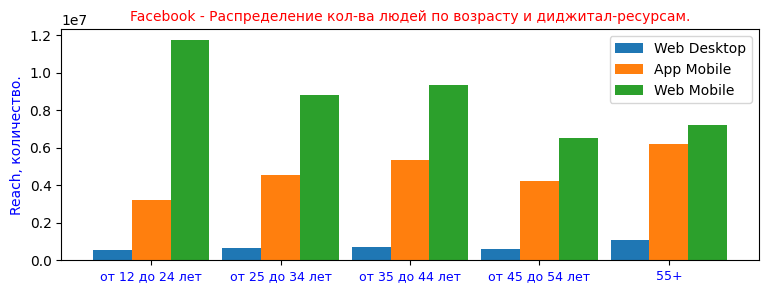

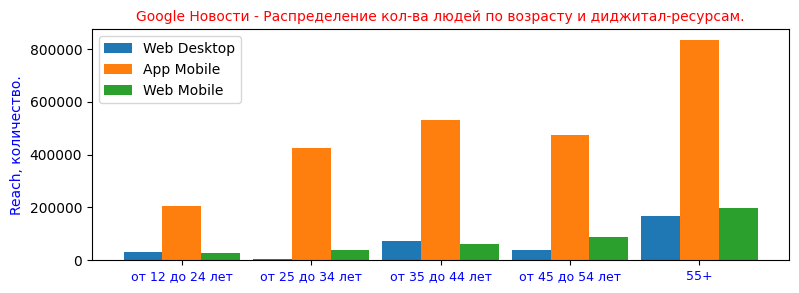

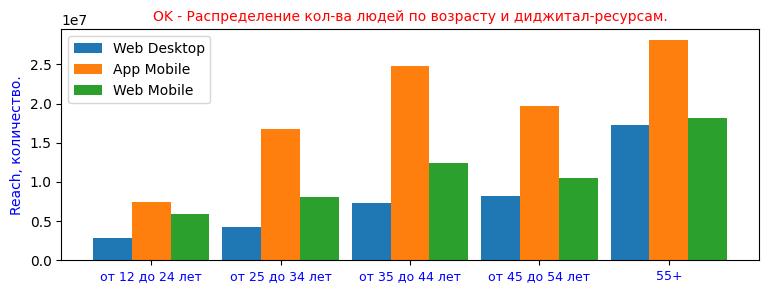

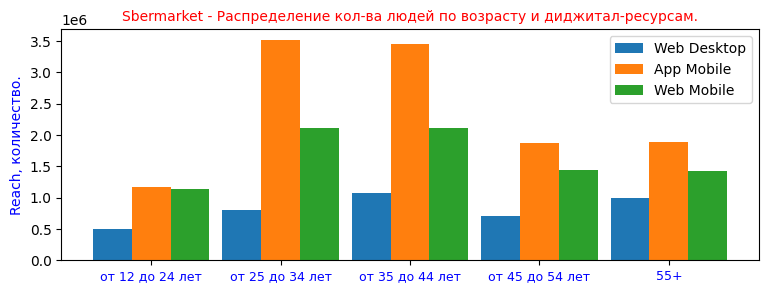

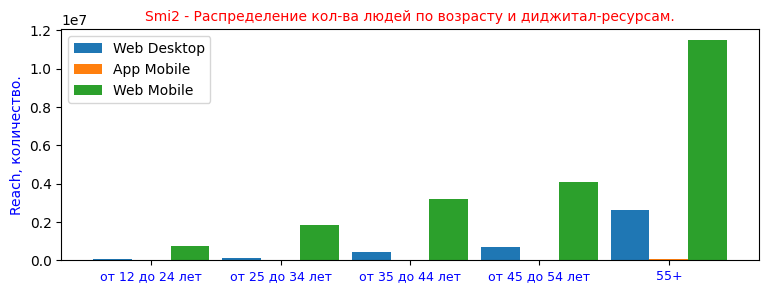

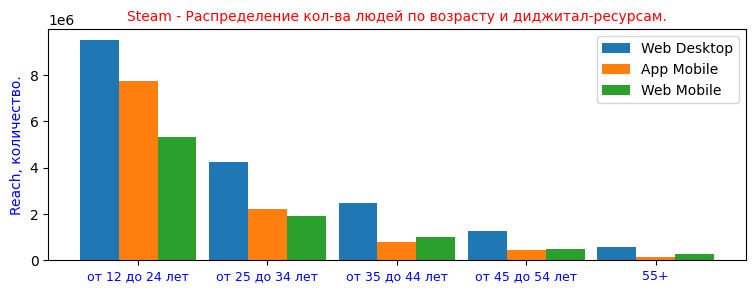

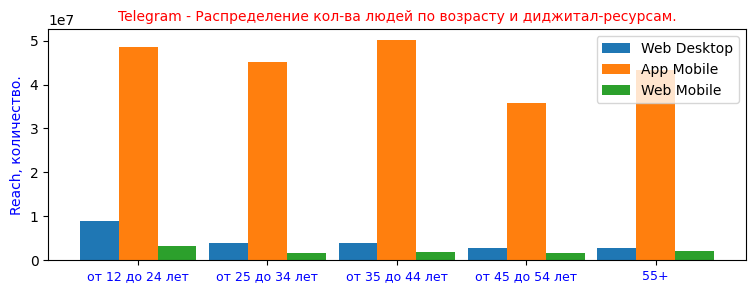

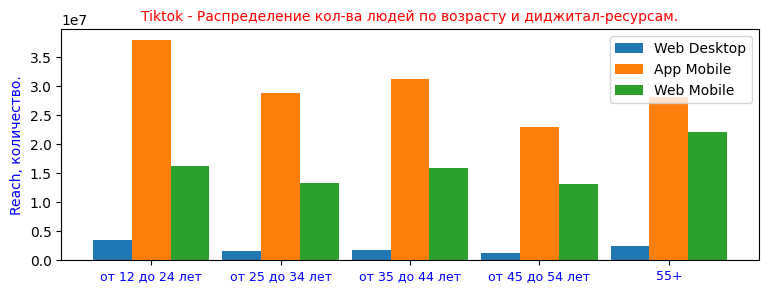

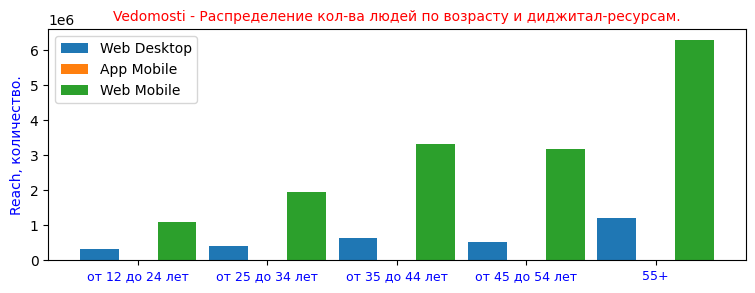

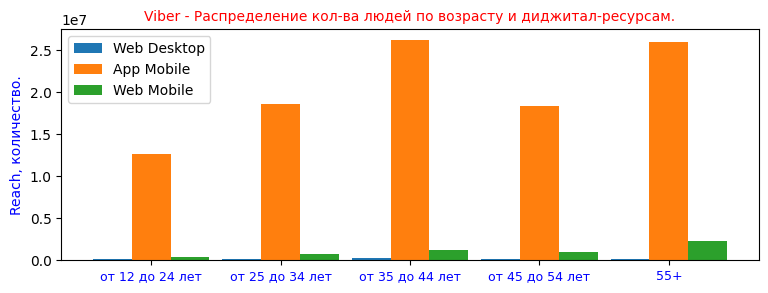

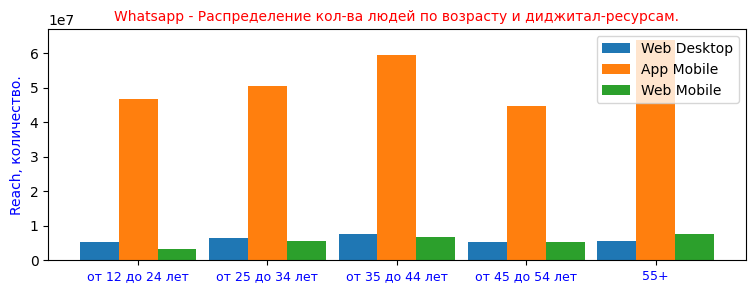

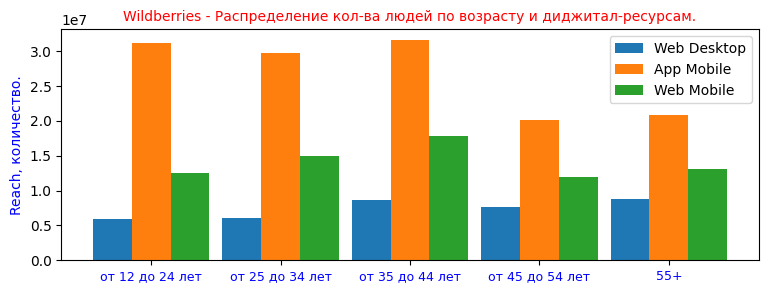

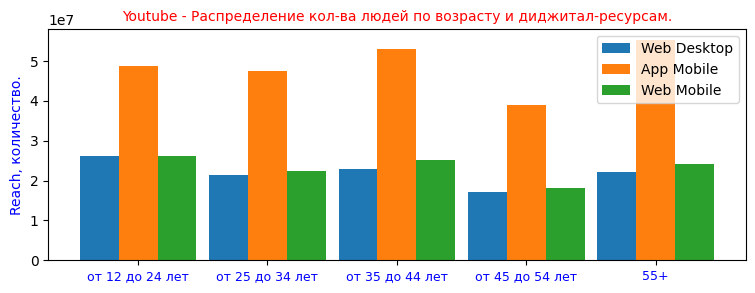

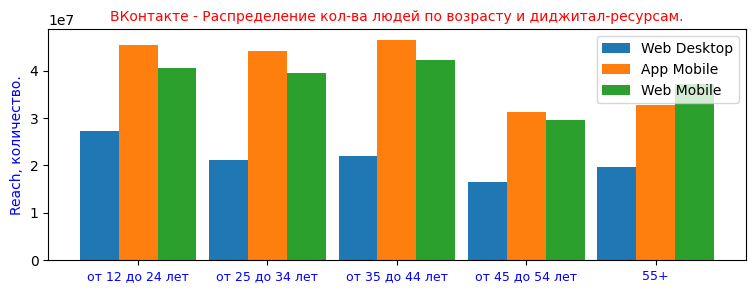

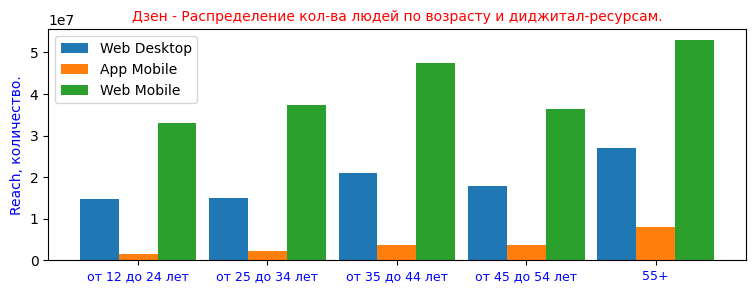

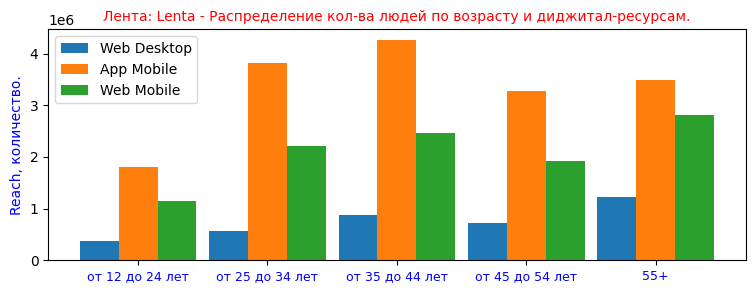

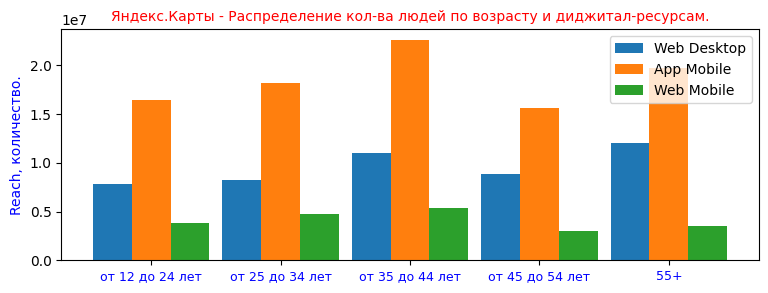

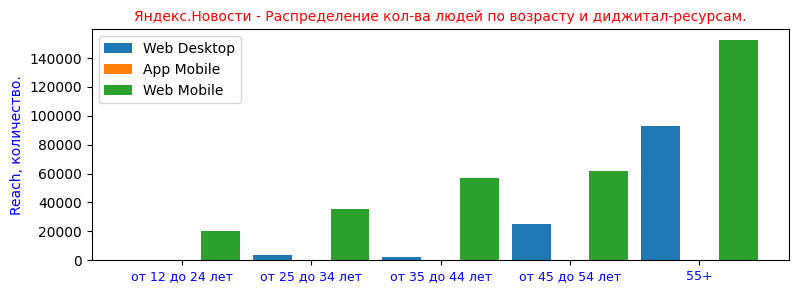

In [15]:
ages_list = ['от 12 до 24 лет', 'от 25 до 34 лет',
             'от 35 до 44 лет', 'от 45 до 54 лет', '55+']

device_list = list_columns_3[:6][0::2]
str1 = device_list[0].split()
label1 = str1[2]+' '+str1[3]

str2 = device_list[1].split()
label2 = str2[2]+' '+str2[3]

str3 = device_list[2].split()
label3 = str3[2]+' '+str3[3]

for num_row in range(new.shape[0]):

    y1 = list(new.loc[num_row][1::6]) 
    y2 = list(new.loc[num_row][3::6])
    y3 = list(new.loc[num_row][5::6])

    width = 0.3
    x = np.arange(len(ages_list))

    fig, ax = plt.subplots(figsize=(9, 3))
    rects1 = ax.bar(x - width, y1, width, label=label1)
    rects2 = ax.bar(x,         y2, width, label=label2)
    rects2 = ax.bar(x + width, y3, width, label=label3)
    ax.set_title(new.loc[num_row][0]+\
        ' - Распределение кол-ва людей по возрасту и диджитал-ресурсам.',
        fontsize = 10, color = 'red')
    ax.set_xticks(x)
    ax.set_xticklabels(ages_list, fontsize = 9, color = 'blue')
    ax.set_ylabel('Reach, количество.', fontsize = 10, color = 'blue')
    ax.legend()

**Промежуточные выводы** по распределению количества людей по возрастным группам и устройствами контакта - Web Desktop (ПК и ноутбуки), App Mobile (Мобильное приложение), Web Mobile (Мобильный браузер), пользующихся интернет-ресурсами.   
1. `2gis`:
* Пользователи двух групп в возрасте от 25 до 44 лет активнее других пользуются мобильными приложениями.
* Для этих же пользователей на втором месте по популярности мобильные браузеры.
* Люди старшего возраста (55+) чаще пользуются стационарными устройствами (ПК и ноутбуки), чем более молодые.
2. `Discord`:
* Один из менее популярных интернет-ресурсов. Исключение составляет только молодые люди (12 – 24 года), использующие App Mobile (Мобильные приложения). 
3. `Facebook`:
* Для всех возрастных категорий очень НЕпопулярен Web Desktop (ПК и ноутбуки).
* Самым популярным для всех пользователей является мобильные браузеры. Их использование имеет тенденцию к снижению процентов на 20-30 от молодых людей к категории ‘55+’.
* Вторым по популярности является мобильное приложение, которое показывает противоположную тенденцию, становясь более популярным с возрастом людей.
4. `Google Карты`:
* Все люди пользуются в основном мобильными приложениями, так как, по-видимому, используют навигаторы в дороге, в автомобиле …
5. `Google Новости`:
* Снова используют в основном с мобильных приложений, возможно тоже в дороге.
* Один из менее посещаемых интернет-ресурсов, видимо в силу политических причин.
6. `Кр`:
* В основном люди используют мобильный браузер и практически не заходят на него с мобильных приложений.
7. `Mail // Новости`:
* наиболее часто заходят через ПК или ноутбуки,
* частота использования через Web Desktop повышается с возрастом. По-видимому, люди старшего возраста привыкли так пользоваться новостями mail.ru.
8. `Ок`.
* Следует отметить растущую популярность ресурса с возрастом людей.
9. `Sbermarket`:
* больше всего используется людьми их двух категорий, в сумме от 25 до 44 лет.
* все пользователи чаще заходят с мобильных приложений.
10. `Sbermegamarket`:
* наиболее популярен у людей среднего возраста, ‘от 35 до 44 лет’;
* все пользователи предпочитают работать через мобильный браузер.
* на втором месте по популярности – заходить с ПК и ноутбуков.
11. `Smi2`:
* Практически не используются мобильное приложение для работы с этим ресурсом.
* Чаще всего пользователи заходят с мобильных браузеров.
* Более популярен у людей старшего возраста, видимо по привычке.
12. `Steam`:
* Популярен у людей младшего возраста.
* Частота использования сильно падает с увеличением возрастной категории людей.
13. `Telegram`:
* Практически все пользуются с мобильных приложений!
14. `Tiktok`:
* Все люди чаще всего заходят с мобильных приложений.
* Практически не пользуются с ПК и ноутбуков.
15. `Vedomosti`:
* Практически не используются в мобильных приложениях.
* Популярность растёт с возрастом пользователей.
* Наиболее часто заходят через мобильный браузер.
16. `Viber`.
* Не применятся с ПК и ноутбуков. Видимо, у всех установлен на смартфонах в качестве мобильного приложения.
17. `WhatsApp`:
* Тоже, как мобильное приложение, установлен у всех на смартфонах.
* Другие устройства не популярны для работы с ним.
18. `Wildberries`:
* Люди выбирают товары в основном на мобильных приложениях и реже на стационарных устройствах (ПК или ноутбук).
19. `Youtube`:
* Практически все категории пользователей устанавливают мобильное приложение на смартфонах, и раза в 2 реже используют через мобильные браузеры, ПК и ноутбуки.
20. `ВКонтакте`:
* Чаще всего люди заходят через мобильные приложения или мобильные браузеры, и раза в 2 реже через ПК и ноутбуки.
21. `Дзен`:
* Наименее редко используют мобильное приложение, чаще ПК и ноутбуки, и ещё в 2 раза через мобильные браузеры.
22. `Лента`:
* Наиболее часто заходят с мобильного приложения.
* С ПК или ноутбука – реже.
23. `Яндекс.Картинки`:
* Используют в работе на стационарных компьютерах.
* Раза в 2 реже через мобильные браузеры.
* совсем нет популярных мобильных приложений.
24. `Яндекс.Карты`:
* Чаще используются в навигаторах через мобильное приложение. 
* Раза в 2 реже люди изучают маршрут на ПК и ноутбуках.
* Мобильные браузеры используют реже всего. Мобильные приложения удобнее.
25. `Яндекс.Новости`:
* Судя по количеству пользователей, это самый непопулярный ресурс из всех рассмотренных. 
* Мобильное приложение не используется.
* Чаще всего люди пользуются мобильными браузерами на смартфонах.
* Люди старшего возраста, особенно ‘55+’ и чуть меньше ’45-54’ любят читать Яндекс-Новости на ПК или ноутбуке.

## 4.3. Самое популярное устройство контакта.

Просуммируем количество контактов по всем интернет-ресурсам.

In [16]:
new_total = new.sum()

list_x = []
for col in new.columns[1::2]:
    list_x.append('  ' + col.split(':')[1])

list_y = []
for name_col in new.columns[1::2]:
    list_y.append(new_total[name_col])

**Распределение кол-ва пользователей по возрасту и устройствам контакта.**

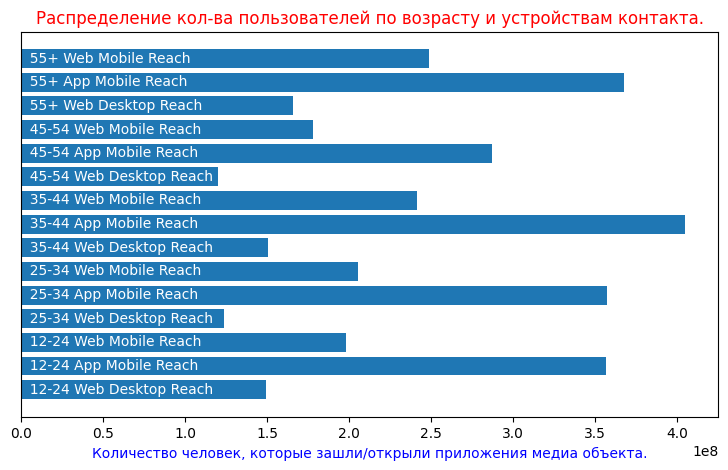

In [17]:
fig, ax = plt.subplots(figsize=(9,5))

plt.title('Распределение кол-ва пользователей по возрасту и устройствам контакта.',
         color = 'red')
plt.xlabel("Количество человек, которые зашли/открыли приложения медиа объекта.",
         color = 'blue')  
ax.axes.yaxis.set_ticks([])

barlist = plt.barh(list_x, list_y)



y = [i * 1 for i in range(len(list_x))]

PAD = 0.5
for name, count, y_pos in zip(list_x, list_y, y):
    ax.text(PAD, y_pos + 0.03, name,
            color="white", fontsize=10, va="center")

plt.show()

**Отмечаем**, что мобильные приложения являются наиболее популярными для всех категорий пользователей.

**Лидер среди устройств контакта с интернет-ресурсами.**

In [18]:
sum1, sum2, sum3 = 0, 0, 0

for num in range(0, len(list_y), 3):
    sum1 += list_y[num]
    sum2 += list_y[num+1]
    sum3 += list_y[num+2]

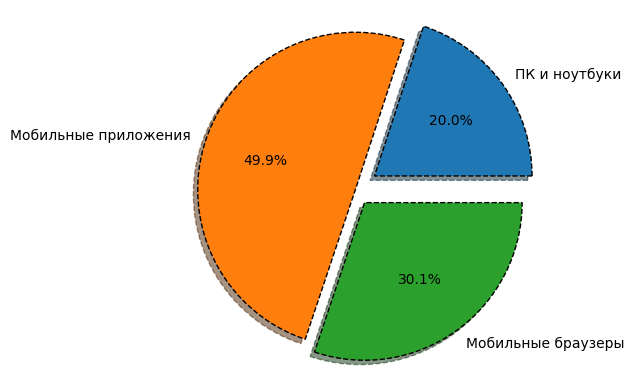

In [19]:
vals = [sum1, sum2, sum3]
labels = ['ПК и ноутбуки', 'Мобильные приложения', 'Мобильные браузеры']
explode = (0.15, 0, 0.1)
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True,
explode=explode, wedgeprops={'lw':1, 'ls':'--','edgecolor':'k'})
ax.axis('equal');

**Отмечаем**:
* Лидерами по использованию являются мобильные приложения.
* ПК и ноутбуки теряют популярность и уступают лидеру в популярности примерно в 2,5 раза.

**Распределение количествава пользователей интернет-ресурсов по возрасту.**

In [20]:
list_y_age = []
n, sum = 0, 0
for volume in list_y:
    sum += volume
    n += 1
    
    if (n >=3 ):
        list_y_age.append(sum)
        sum = 0
        n = 0

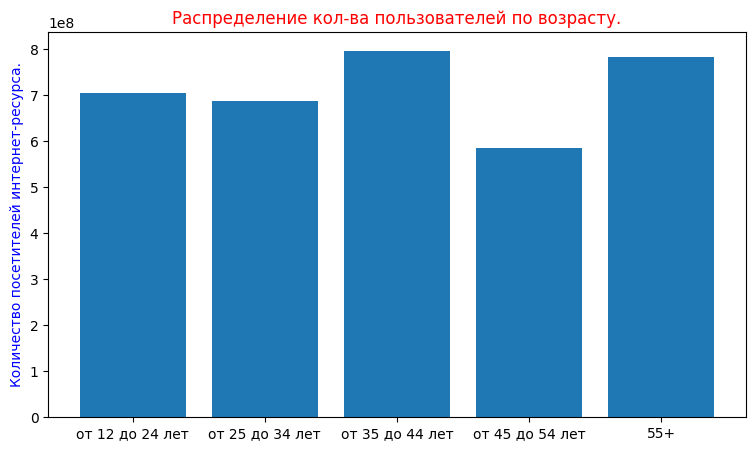

In [21]:
fig, ax = plt.subplots(figsize=(9,5))
plt.title('Распределение кол-ва пользователей по возрасту.',
         color = 'red')
plt.ylabel("Количество посетителей интернет-ресурса.",
         color = 'blue')  
plt.bar(ages_list, list_y_age)
plt.show()

**Отмечаем**, что наиболее активными потребителями интернет ресурсов являются являются люди среднего возраста (35-44 года) и люди старшего возраста (55+). Интересно!

## 4.4. Динамика изменения распределения количества запросов интернет-ресурсов по месяцам.

Диапазон исследуемых месяцев: апрель 2023, май 2023, июнь 2023.
Устройства контакта: Web Desktop (ПК и ноутбуки), App Mobile (Мобильное приложение), Web Mobile (Мобильный браузер)

In [22]:
df_reach_total

Name  Апрель 2023 Web Desktop Reach  \
0                 2gis                     6726477.00   
1              Discord                     3983267.00   
2             Facebook                     1323813.00   
3         Google Карты                     5050247.00   
4       Google Новости                       91760.00   
5                   Kp                     5653997.00   
6   Mail.ru // Новости                     6684217.00   
7                   OK                    14116883.00   
8           Sbermarket                     1343483.00   
9       Sbermegamarket                     4683143.00   
10                Smi2                     1266777.00   
11               Steam                     6004210.00   
12            Telegram                     7481697.00   
13              Tiktok                     3859923.00   
14           Vedomosti                      947627.00   
15               Viber                      337823.00   
16            Whatsapp                    10583603.00   
17         Wildberries                    12351090.00   
18             Youtube                    37627150.00   
19           ВКонтакте                    36584547.00   
20                Дзен                    32355630.00   
21        Лента: Lenta                     1371897.00   
22     Яндекс.Картинки                    26953253.00   
23        Яндекс.Карты                    16401673.00   
24      Яндекс.Новости                       53790.00   

    Апрель 2023 Web Desktop ReachPer  Апрель 2023 App Mobile Reach  \
0                               5.52                   18460867.00   
1                               3.27                    7650027.00   
2                               1.09                    8462283.00   
3                               4.15                   30605257.00   
4                               0.08                     871037.00   
5                               4.64                      22840.00   
6                               5.49                    1157997.00   
7                              11.60                   32536853.00   
8                               1.10                    3867617.00   
9                               3.85                    3490003.00   
10                              1.04                      19433.00   
11                              4.93                    3793370.00   
12                              6.15                   73978897.00   
13                              3.17                   50147043.00   
14                              0.78                       4997.00   
15                              0.28                   34021530.00   
16                              8.69                   88418413.00   
17                             10.14                   43709733.00   
18                             30.91                   81292277.00   
19                             30.05                   66477073.00   
20                             26.58                    6447407.00   
21                              1.13                    5727843.00   
22                             22.14                           NaN   
23                             13.47                   30052063.00   
24                              0.04                           NaN   

    Апрель 2023 App Mobile ReachPer  Апрель 2023 Web Mobile Reach  \
0                             15.16                   11626513.00   
1                              6.28                    2437420.00   
2                              6.95                   15061037.00   
3                             25.14                    1752010.00   
4                              0.72                     138050.00   
5                              0.02                   19654610.00   
6                              0.95                    2393643.00   
7                             26.72                   19946953.00   
8                              3.18                    1998037.00   
9                       

In [23]:
list_device = list(df_reach_total.columns[1::2]) # Уберем колонку Name и все ReachPer

list_full = []
for graph in range(0, 3):
    list_single = []
    for num in range(0, 3):
        list_single.append(list_device[graph + num*3])
    list_full.append(list_single )    

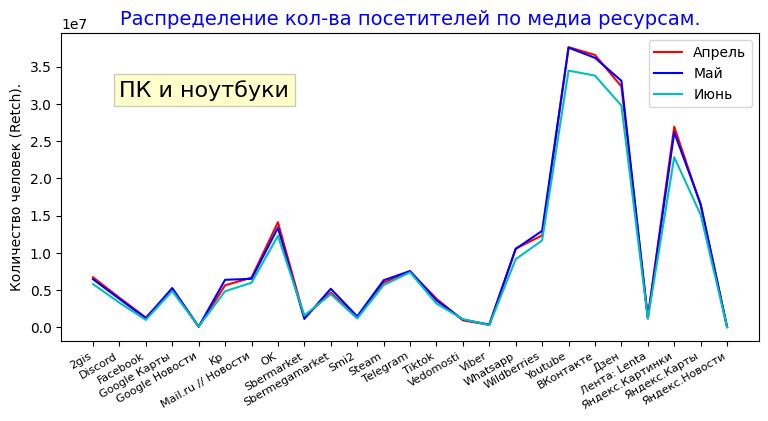

In [24]:
x = [i for i in range(25)]
labels = list(df_reach_total['Name'])
list_device = list(df_reach_total.columns[1:6:2]) # Уберем Name и ReachPer

name = ['ПК и ноутбуки','Мобильные приложения','Мобильные браузеры']
color = ['-r', '-b', '-c']
pos = [3.1e7, 8e7, 6e7] 

for graph in range(3):
    plt.figure(figsize=(9, 4))      
    plt.title('Распределение кол-ва посетителей по медиа ресурсам.', 
                  fontsize=14, color='blue')
    plt.ylabel('Количество человек (Retch).')
    for num in range(0, 3):
        plt.plot(x, df_reach_total[list_full[graph][num]], 
                 color[num], label=list_full[graph][num].split()[0])
    plt.text(1.0, pos[graph], name[graph], 
             fontsize=16, bbox={'facecolor':'yellow','alpha':0.2}) 
    plt.xticks(x, labels)
    plt.xticks(rotation=30, ha='right', fontsize = 8)
    plt.legend(loc='upper right')
    plt.show()

**Промежуточные выводы**:
1. `ПК и ноутбуки`.   
* Больше всего посетителей через *Yuotube*, *ВКонтакте*, *Дзен*. 
* В июне, по сравнению с двумя предыдущими месяцами, посещаемость упала, видимо это связано с начавшимся периодом отпусков и не доступностью стационарных (чаще офисных) компьютеров.
2. `Мобильные приложения`.  
* Больше всего пользователей мессенджеров *Whatsapp*, *Yuotube*, *Telegram* и *ВКонтакте*. 
* Динамика отсутствует. Падения интереса к интернет-ресурсам не наблюдается. Смартфон всегда с собой, "под рукой".
3. `Мобильные браузеры`.   
* Больше всего посетителей у *ВКонтакте*, *Дзен* и *Yuotube*.
* В июне, по сравнению с двумя предыдущими месяцами, посещаемость уменьшилась, что тоде связано с отпускным периодом.

<hr style='border:2px solid #460073'> </hr>
<h1 style='color: #460073'>5. Итоговые выводы.</h1> 
<hr style='border:2px solid #460073'> </hr>

**По результатам исследования можно отметить следующие факты и сделать приводимые ниже выводы:**

1. Для проведения исследования получены данные, накопленные за апрель - июнь 2023 г.
2. В файле `Reach000%` содержатся данные по популярным 25 интернет-ресурсам. Их выделили в два файла:
    * `Reach000%_total` - данные по каждому интернет-ресурсу с разбивкой по трем месяцам (апрель, май, июнь) и трем устройствам контакта (*Web Desktop* (ПК и ноутбуки), *App Mobile* (Мобильное приложение), *Web Mobile* (Мобильный браузер)). Всего 25 записей и 19 признаков. 
    * `Reach000%_3` - данные по каждому интернет-ресурсу, отдельно по трем месяцам (апрель, май, июнь), с разбивкой по трем устройствам контакта (*Web Desktop* (ПК и ноутбуки), *App Mobile* (Мобильное приложение), *Web Mobile* (Мобильный браузер)) и шести возрастным группам: *до 12 лет*, *от 12 до 24 лет*, *от 24 до 34 лет*, *от 34 до 44 лет*, *от 44 до 54 лет*, *от 55 лет* . Всего 75 записей и 32 признака. 
3. Провёл первичную обработку данных.
4. Решаемые задачи в рамках EDA анализа:
    * Задача 1. Изучил распределение количества посетителей интернет-ресурсов по возрастным категориям и устройствам контакта суммарно по всем месяцам.
    * Задача 2. Проанализировал динамику изменения распределения количества запросов интернет-ресурсов по месяцам.
5. По результатам *задачи 1*, по распределению количества людей по возрастным группам и устройствами контакта - Web Desktop (ПК и ноутбуки), App Mobile (Мобильное приложение), Web Mobile (Мобильный браузер), пользующихся интернет-ресурсами установлено:

5.1. `2gis`:  
    * Пользователи двух групп в возрасте от 25 до 44 лет активнее других пользуются мобильными приложениями.  
    * Для этих же пользователей на втором месте по популярности мобильные браузеры.  
    * Люди старшего возраста (55+) чаще пользуются стационарными устройствами (ПК и ноутбуки), чем более молодые.   

5.2. `Discord`:  
    * Один из менее популярных интернет-ресурсов. Исключение составляет только молодые люди (12 – 24 года), использующие App Mobile (Мобильные приложения).    

5.3. `Facebook`:  
    * Для всех возрастных категорий очень НЕпопулярен Web Desktop (ПК и ноутбуки).  
    * Самым популярным для всех пользователей является мобильные браузеры. Их использование имеет тенденцию к снижению процентов на 20-30 от молодых людей к категории ‘55+’.  
    * Вторым по популярности является мобильное приложение, которое показывает противоположную тенденцию, становясь более популярным с возрастом людей.   

5.4. `Google Карты`:  
    * Все люди пользуются в основном мобильными приложениями, так как, по-видимому, используют навигаторы в дороге, в автомобиле …   

5.5. `Google Новости`:  
    * Снова используют в основном с мобильных приложений, возможно тоже в дороге.  
    * Один из менее посещаемых интернет-ресурсов, видимо в силу политических причин.     

5.6. `Кр`:  
    * В основном люди используют мобильный браузер и практически не заходят на него с мобильных приложений.   

5.7. `Mail // Новости`:  
    * наиболее часто заходят через ПК или ноутбуки,  
    * частота использования через Web Desktop повышается с возрастом. По-видимому, люди старшего возраста привыкли так пользоваться новостями mail.ru.   

5.8. `Ок`.  
    * Следует отметить растущую популярность ресурса с возрастом людей.  

5.9. `Sbermarket`:  
    * больше всего используется людьми их двух категорий, в сумме от 25 до 44 лет,  
    * все пользователи чаще заходят с мобильных приложений.  

5.10. `Sbermegamarket`:  
    * наиболее популярен у людей среднего возраста, ‘от 35 до 44 лет’;  
    * все пользователи предпочитают работать через мобильный браузер;  
    * на втором месте по популярности – заходить с ПК и ноутбуков.  

5.11. `Smi2`:  
    * Практически не используются мобильное приложение для работы с этим ресурсом.  
    * Чаще всего пользователи заходят с мобильных браузеров.  
    * Более популярен у людей старшего возраста, видимо по привычке.  

5.12. `Steam`:  
    * Популярен у людей младшего возраста.  
    * Частота использования сильно падает с увеличением возрастной категории людей.  

5.13. `Telegram`:  
    * Практически все пользуются с мобильных приложений!  

5.14. `Tiktok`:  
    * Все люди чаще всего заходят с мобильных приложений.  
    * Практически не пользуются с ПК и ноутбуков.  

5.15. `Vedomosti`:  
    * Практически не используются в мобильных приложениях.  
    * Популярность растёт с возрастом пользователей.  
    * Наиболее часто заходят через мобильный браузер.  

5.16. `Viber`.  
    * Не применятся с ПК и ноутбуков. Видимо, у всех установлен на смартфонах в качестве мобильного приложения.  

5.17. `WhatsApp`:  
    * Тоже, как мобильное приложение, установлен у всех на смартфонах.  
    * Другие устройства не популярны для работы с ним.  

5.18. `Wildberries`:  
    * Люди выбирают товары в основном на мобильных приложениях и реже на стационарных устройствах (ПК или ноутбук).  

5.19. `Youtube`:  
    * Практически все категории пользователей устанавливают мобильное приложение на смартфонах, и раза в 2 реже используют через мобильные браузеры, ПК и ноутбуки.  

5.20. `ВКонтакте`:  
    * Чаще всего люди заходят через мобильные приложения или мобильные браузеры, и раза в 2 реже через ПК и ноутбуки.  

5.21. `Дзен`:  
    * Наименее редко используют мобильное приложение, чаще ПК и ноутбуки, и ещё в 2 раза через мобильные браузеры.  

5.22. `Лента`:  
    * Наиболее часто заходят с мобильного приложения.  
    * С ПК или ноутбука – реже.  

5.23. `Яндекс.Картинки`:  
    * Используют в работе на стационарных компьютерах.  
    * Раза в 2 реже через мобильные браузеры.  
    * совсем нет популярных мобильных приложений.  

5.24. `Яндекс.Карты`:  
    * Чаще используются в навигаторах через мобильное приложение.   
    * Раза в 2 реже люди изучают маршрут на ПК и ноутбуках.  
    * Мобильные браузеры используют реже всего. Мобильные приложения удобнее.  

5.25. `Яндекс.Новости`:  
    * Судя по количеству пользователей, это самый непопулярный ресурс из всех рассмотренных.   
    * Мобильное приложение не используется.  
    * Чаще всего люди пользуются мобильными браузерами на смартфонах.  
    * Люди старшего возраста, особенно ‘55+’ и чуть меньше ’45-54’ любят читать Яндекс-Новости на ПК или ноутбуке.   
    
6. По результатам *задачи 2*, c распределениtv количества запросов интернет-ресурсов по месяцам и устройствам контакта установлено:  

6.1. `ПК и ноутбуки`.     
* Больше всего посетителей через *Yuotube*, *ВКонтакте*, *Дзен*.  
* В июне, по сравнению с двумя предыдущими месяцами, посещаемость упала, видимо это связано с начавшимся периодом отпусков и не доступностью стационарных (чаще офисных) компьютеров.  

6.2. `Мобильные приложения`.    
* Больше всего пользователей мессенджеров *Whatsapp*, *Yuotube*, *Telegram* и *ВКонтакте*.   
* Динамика отсутствует. Падения интереса к интернет-ресурсам не наблюдается. Смартфон всегда с собой, "под рукой".  

6.3. `Мобильные браузеры`.     
* Больше всего посетителей у *ВКонтакте*, *Дзен* и *Yuotube*.  
* В июне, по сравнению с двумя предыдущими месяцами, посещаемость уменьшилась, что тоде связано с отпускным периодом.  